# 1. Data Preprocess

In [ ]:
# Import the libraries
import tensorflow.keras
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.activations import softmax
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras import preprocessing, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

## 1.1 Data Collection 

Download the datasets from [Cornell Movie Datasets Website](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html) and unzip the data into txt files.



In [ ]:
! wget -nc "http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip"
! unzip cornell_movie_dialogs_corpus.zip
! rm cornell_movie_dialogs_corpus.zip

--2022-04-26 16:21:30--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  12.5MB/s    in 0.8s    

2022-04-26 16:21:31 (12.5 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]

Archive:  cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf  
  inflating: cornell movie-

## 1.2 Data Cleaning & Wrangling

Clean the data and convert it into the form of a dialog. We only care about "movie_lines.txt" and "movie_conversations.txt". The former one consists of [Line Number, Movie ID, Line Contents] and the latter one is comprised of all the conversations(i.e. lists of line numbers).

e.g.:  

L1045 +++\$+++ u0 +++\$+++ m0 +++\$+++ BIANCA +++\$+++ They do not!

u0 +++\$+++ u2 +++\$+++ m0 +++\$+++ ['L194', 'L195', 'L196', 'L197']


In [ ]:
# open dialog files
movie_lines = open('cornell movie-dialogs corpus/movie_lines.txt', encoding='utf-8',errors='ignore').read().split('\n')
movie_conversations = open('cornell movie-dialogs corpus/movie_conversations.txt', encoding='utf-8',errors='ignore').read().split('\n')

In [ ]:
# build a dictionary to record (line_number, dialog) mappings
line_to_dialog = {}
for line in movie_lines:
  line_splited = line.split(' +++$+++ ')
  line_to_dialog[line_splited[0]] = line_splited[-1]

In [ ]:
# build dialog fragments
dialog_fragments = []
for conversation in movie_conversations:
  ## convert u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197'] to 'L194', 'L195', 'L196', 'L197'
  dialog_instance = conversation.split(' +++$+++ ')[-1][1:-1]
  ## convert 'L194', 'L195', 'L196', 'L197' to ['L194', 'L195', 'L196', 'L197']
  dialog_fragments.append(dialog_instance.replace("'", " ").replace(",","").split())

In [ ]:
# convert dialog fragments into (question, answer) pairs
questions = []
answers = []

for frag in dialog_fragments:
    for i in range(1, len(frag)):
        questions.append(line_to_dialog[frag[i-1]])
        answers.append(line_to_dialog[frag[i]])

In [ ]:
# show questions and answers pairs
def qa_show(num):
  for i in range(num):
    print('-------------------------------------------------\n')
    print(f"Dialog A: {questions[i]}\n")
    print(f"Dialog B: {answers[i]}\n")

qa_show(5)

-------------------------------------------------

Dialog A: Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.

Dialog B: Well, I thought we'd start with pronunciation, if that's okay with you.

-------------------------------------------------

Dialog A: Well, I thought we'd start with pronunciation, if that's okay with you.

Dialog B: Not the hacking and gagging and spitting part.  Please.

-------------------------------------------------

Dialog A: Not the hacking and gagging and spitting part.  Please.

Dialog B: Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

-------------------------------------------------

Dialog A: You're asking me out.  That's so cute. What's your name again?

Dialog B: Forget it.

-------------------------------------------------

Dialog A: No, no, it's my fault -- we didn't have a proper introduction ---

Dialog B: Cameron.



## 1.3 Text Preprocessing

After we clean the datasets, we need to further process the texts of each question and answer. We also filter out some long questions and answers(not friendly for training the model).

Set the global variables here

* TEXT_LIMIT: only keep the questions and answers whose number of words is no more than `TEXT_LIMIT`.


### 1.3.1 Filter out long Q&A

In [ ]:
# Global variables
TEXT_LIMIT = 15

In [ ]:
# filter out long dialogs
def filter_long_texts(questions, answers, limit):
    short_questions = []
    short_answers = []
    for i in range(len(questions)):
        if len(questions[i]) <= TEXT_LIMIT and len(answers[i]) <=TEXT_LIMIT:
        # if len(questions[i].split()) <= TEXT_LIMIT:
            short_questions.append(questions[i])
            short_answers.append(answers[i])
    return short_questions, short_answers

In [ ]:
filtered_questions, filtered_answers = filter_long_texts(questions, answers, TEXT_LIMIT)

### 1.3.2 Process the texts

1. Make all the text lower case
2. Remove contractions (e.g. she's -> she is, they're -> they are, etc.).
3. Remove the punctuation (e.g. !, ?, $, %, #, @, ^, etc.).
4. Tokenization.
5. Pad the sequences to be the same length(defined as TEXT_LIMIT above).

In [ ]:
# clean the texts

replacement_patterns = [
  (r'won\'t', 'will not'),
  (r'can\'t', 'cannot'),
  (r'i\'m', 'i am'),
  (r'ain\'t', 'is not'),
  (r'(\w+)\'ll', '\g<1> will'),
  (r'(\w+)n\'t', '\g<1> not'),
  (r'(\w+)\'ve', '\g<1> have'),
  (r'(\w+)\'s', '\g<1> is'),
  (r'(\w+)\'re', '\g<1> are'),
  (r'(\w+)\'d', '\g<1> would'),
]

class TextCleaner(object):
  def __init__(self, patterns=replacement_patterns):
    self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    
  def replace(self, text):
    s = text
    for (pattern, replace) in self.patterns:
      s = re.sub(pattern, replace, s)
    return s

cleaner = TextCleaner()

# Function for preprocessing the given text
def preprocess_text(text):
    
    # Lowercase the text
    text = text.lower() 
    # Decontracting the text (e.g. it's -> it is)
    text = cleaner.replace(text)
    # Remove the punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # Remove extra spaces
    text = re.sub(r"[ ]+", " ", text)
    
    return text

In [ ]:
cleaned_questions = [preprocess_text(que) for que in filtered_questions]
cleaned_answers = [' '.join(ans.split()[:TEXT_LIMIT-2]) for ans in filtered_answers]

for i in range(50):
    print('-------------------------------------------------\n')
    print(f'Dialog A: {cleaned_questions[i]}\n')
    print(f'Dialog B: {cleaned_answers[i]}\n')

-------------------------------------------------

Dialog A: there 

Dialog B: Where?

-------------------------------------------------

Dialog A: wow

Dialog B: Let's go.

-------------------------------------------------

Dialog A: she okay 

Dialog B: I hope so.

-------------------------------------------------

Dialog A: they do to 

Dialog B: They do not!

-------------------------------------------------

Dialog A: who 

Dialog B: Joey.

-------------------------------------------------

Dialog A: it is more

Dialog B: Expensive?

-------------------------------------------------

Dialog A: let go 

Dialog B: You set me up.

-------------------------------------------------

Dialog A: thirty two 

Dialog B: Get out!

-------------------------------------------------

Dialog A: she kissed me 

Dialog B: Where?

-------------------------------------------------

Dialog A: where ya goin 

Dialog B: Away.

-------------------------------------------------

Dialog A: hey 

Dialog B:

### 1.3.3 Add Tag Tokens

After preprocessing the dataset, we should add a start tag (e.g. `<start>`) and an end tag (e.g. `<end>`) to answers. Remember that we will only add these tags to answers and not questions.

When Seq2Seq model is generating the word answers, we can first send it the `<start>` to begin the word generation. When `<end>` is generated, we will stop the iteration.


In [ ]:
cleaned_answers = ["starttoken " + ans + " endtoken" for ans in cleaned_answers]

### 1.3.4 Truncate the Datasets

In [ ]:
# trim the data in case of running out of RAM

# TRAINING_SIZE = 100000

## Version 1: Take all data
training_questions = cleaned_questions
training_answers = cleaned_answers

# Version 1: Take first TRAINING_SIZE data
# training_questions = cleaned_questions[:TRAINING_SIZE]
# training_answers = cleaned_answers[:TRAINING_SIZE]

# testing_questions = cleaned_questions[TRAINING_SIZE:]
# testing_answers = cleaned_answers[TRAINING_SIZE:]

## 1.4 Input Encoding

Since String inputs cannot been directly fed into our RNN model, we have to convet String input into numerical values.


### 1.4.1 Choose Vocabulary Size 

The size of vocabulary based on the training datasets will be very large. Some of them only appears once or twice. We want to keep the most common words while maitain the diversity of expressions, so we need to figure out how many words to keep.

First, figure out the frequence of each words in the questions and answers.

In [ ]:
word2frequency = {}
for sent in cleaned_questions + cleaned_answers:
    for word in sent.split():
        if word in word2frequency:
            word2frequency[word] += 1
        else:
            word2frequency[word] = 1

In [ ]:
FREQUENCY_THRESHOLD = 10
cumulative_num_words_by_threshold = [0 for i in range(FREQUENCY_THRESHOLD)]

for word in word2frequency:
    for i in range(1, FREQUENCY_THRESHOLD+1):
        if word2frequency[word] >= i:
            cumulative_num_words_by_threshold[i-1] += 1
        else:
            break
cumulative_num_words_by_threshold

[7799, 2540, 1518, 1108, 890, 752, 664, 585, 525, 469]

Then, visualize the Word Frequency 

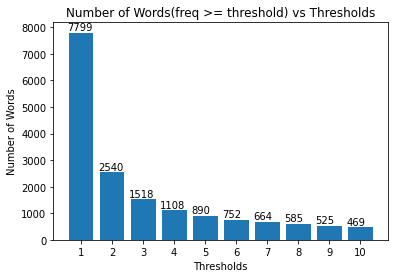

In [ ]:
X = [i+1 for i in range(FREQUENCY_THRESHOLD)]

# bar plot the data
plt.bar(X, height=cumulative_num_words_by_threshold)

# add value to the top of the bar, making the plot more clear
for index,data in enumerate(cumulative_num_words_by_threshold):
    plt.text(x=index+0.55, y =data+100 , s=f"{data}" , fontdict=dict(fontsize=10))

# add plot information
plt.xticks(X, [str(i) for i in X])
plt.xlabel("Thresholds")
plt.ylabel("Number of Words")
plt.title("Number of Words(freq >= threshold) vs Thresholds")

plt.show()

Set global variables here

* NUM_WORDS: Only keep the NUM_WORDS most common words 

In [ ]:
NUM_WORDS = 3500

### 1.4.2 Build the Vocabulary

The words in vocabulary should all come from training datasets. In order to train a good RNN model, we have to discard less common words and try different `NUM_WORDS` to see we is best for our datasets.

* Set the Tokenizer to only keep the NUM_WORDS most common words
* Set the less frequent words as 'nulltoken' 

In [ ]:
# Initialize the tokenizer
tokenizer = preprocessing.text.Tokenizer(num_words = NUM_WORDS, oov_token='nulltoken')

# Fit the tokenizer to questions and answers
tokenizer.fit_on_texts(training_answers + training_answers)

In [ ]:
tokenizer.word_index["endtoken"]

3

### 1.4.3 Prepare the Encoder Input

Since we have successfully built the vocabulary, each word in the vocabulary will corrspond to a unique index according to their frequency. Now convert a question String input into a list of integer as Encoder part of the LSTM network. Later, we can feed the integer values to our model and the predicted results will also be an integer and then we can convert it back to the word the integer number corresponds to based on the vocabulary we build. 

The preparation includes:

* Convert words in questions to corresponding numerical index
* Pad zeros to the end of short questions to make sure all inputs have the same length(TEXT_LIMIT)
* Convert the list of integers into a numpy array.

In [ ]:
### encoder input data

# Tokenize the questions
tokenized_questions_training = tokenizer.texts_to_sequences(training_questions)
# tokenized_questions_testing = tokenizer.texts_to_sequences(testing_questions)

# Pad the sequences
padded_questions_training = pad_sequences(tokenized_questions_training, maxlen=TEXT_LIMIT, padding='post')
# padded_questions_testing = pad_sequences(tokenized_questions_testing, maxlen=TEXT_LIMIT, padding='post')

# Convert the sequences into array
encoder_input_data_training = np.array(padded_questions_training)
print(encoder_input_data_training.shape, TEXT_LIMIT)
# encoder_input_data_testing = np.array(padded_questions_testing)
# print(encoder_input_data_testing.shape, TEXT_LIMIT)

(9905, 15) 15


### 1.4.4 Prepare the Decoder Input

Similarly, what we have done above. Now we convert the answer String inputs to a list of integers as our decoder input.

The preparation includes:

* Convert words in answers to corresponding numerical index
* Pad zeros to the end of short answers to make sure all answers have the same length(TEXT_LIMIT)
* Convert the list of integers into a numpy array.

In [ ]:
### decoder input data

# Tokenize the answers
tokenized_answers_training = tokenizer.texts_to_sequences(training_answers)
# tokenized_answers_testing = tokenizer.texts_to_sequences(testing_answers)

# Pad the sequences
padded_answers_training = pad_sequences(tokenized_answers_training, maxlen=TEXT_LIMIT, padding='post')
# padded_answers_testing = pad_sequences(tokenized_answers_testing, maxlen=TEXT_LIMIT, padding='post')

# Convert the sequences into array
decoder_input_data_training = np.array(padded_answers_training)
print(decoder_input_data_training.shape, TEXT_LIMIT)

# decoder_input_data_testing = np.array(padded_answers_testing)
# print(decoder_input_data_testing.shape, TEXT_LIMIT)

(9905, 15) 15


### 1.4.5 Prepare the Output Labels

 The Chatbot training can be considered as a classification task. Therefore, we use `to_categorical` to converts class vectors (integers) to binary class matrixs as the training labels.

In [ ]:
### decoder_output_data

# Iterate through index of tokenized answers
for i in range(len(tokenized_answers_training)):
    tokenized_answers_training[i] = tokenized_answers_training[i][1:]

# for i in range(len(tokenized_answers_testing)):
#     tokenized_answers_testing[i] = tokenized_answers_testing[i][1:]

# Pad the tokenized answers
padded_answers_training = pad_sequences(tokenized_answers_training, maxlen = TEXT_LIMIT, padding = 'post')
# padded_answers_testing = pad_sequences(tokenized_answers_testing, maxlen = TEXT_LIMIT, padding = 'post')

# One hot encode
onehot_answers_training = utils.to_categorical(padded_answers_training, NUM_WORDS+1)
# onehot_answers_testing = utils.to_categorical(padded_answers_testing, NUM_WORDS+1)

In [ ]:
# Convert to numpy array
decoder_output_data_training = np.array(onehot_answers_training)
del(onehot_answers_training)

# decoder_output_data_testing = np.array(onehot_answers_testing)
# del (onehot_answers_testing)

print(decoder_output_data_training.shape)
# print(decoder_output_data_testing.shape)

(9905, 15, 3501)


# 2. Training RNN Network

In this section, we build a Sequence to Sequence(or Seq2Seq), which includes a Encoder Part and Decoder Part. 

Check the number of GPUs working in the devices. Different from Pytorch, Tensorflow will automatically utilize GPUs resources first and doesn't need to change the codes. 

In [ ]:
## version 1.x
# print("Num GPUs Available: ", tf.config.experimental_list_devices())

# verison 2.x
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 2.1 Build the Training Model

### 2.1.1 Hyperparameter Configuration

Set hyper-parameters for Training Model:

* BATCH_SIZE: Usually a multiple of 2 and no larger than 64
* EPOCHS: number of epochs for training the model
* VOCAB_SIZE: Dimension of categories. It equals to NUM_WORDS + 1 due to `nulltokens`
* embed_dim: Output dimension of embedding layers
* num_lstm: number of units used in LSTM layers


In [ ]:
# Hyper parameters
BATCH_SIZE = 32
EPOCHS = 150
VOCAB_SIZE = NUM_WORDS + 1

embed_dim = 32
num_lstm = 128

### 2.1.2 Build the Encoder part

Parse question input vectors into an Embedding layer, set the input size as (1 + Number of common words kept) where 1 is used for `nulltoken`. Feed the embedding into the LSTM model and keep track of output states and hidden states


In [ ]:
# --------------------------------------------------- 1 layer ---------------------------------------------------------
# # Input for encoder
# encoder_inputs = Input(shape = (None, ), name='encoder_inputs')

# # Embedding layer
# encoder_embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = embed_dim, mask_zero = True, name='encoder_embedding')(encoder_inputs)

# # LSTM layer (that returns states in addition to output)
# encoder_outputs, state_h, state_c = LSTM(units = num_lstm, return_state = True, name='encoder_lstm')(encoder_embedding)

# # Get the states for encoder
# encoder_states = [state_h, state_c]

# --------------------------------------------------- 2 layers ---------------------------------------------------------
# Input for encoder
encoder_inputs = Input(shape = (None, ), name='encoder_inputs')

# Embedding layer
encoder_embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = embed_dim, mask_zero = True, name='encoder_embedding')(encoder_inputs)

# LSTM layer (that returns states in addition to output)
encoder_lstm_output1, h1, c1 = LSTM(units = num_lstm, return_sequences=True, return_state = True, name='encoder_lstm_layer1', recurrent_dropout=0.3)(encoder_embedding)
encoder_outputs, h2, c2 = LSTM(units = num_lstm, return_state = True, name='encoder_lstm_layer2')(encoder_lstm_output1)

# Get the states for encoder
encoder_states = [h1, c1, h2, c2]

### 2.1.3 Build the Decoder part

Parse answer input vectors into an Embedding layer similar to Encoder part, feed the embedding together with encoder output stats and hidden states into decoder LSTM layer. A dense layer is connected to the LSTM and `softmax` is used to do the final classification.


In [ ]:
# --------------------------------------------------- 1 layer ---------------------------------------------------------
# # Input for decoder
# decoder_inputs = Input(shape = (None,  ), name='decoder_inputs')

# # Embedding layer
# decoder_embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = embed_dim , mask_zero = True, name='decoder_embedding')(decoder_inputs)

# # LSTM layer (that returns states and sequences as well)
# decoder_lstm = LSTM(units = num_lstm , return_state = True , return_sequences = True, name='decoder_lstm')

# # Get the output of LSTM layer, using the initial states from the encoder
# decoder_outputs, _, _ = decoder_lstm(inputs = decoder_embedding, initial_state = encoder_states)

# # Dense layer
# decoder_dense = Dense(units = VOCAB_SIZE, activation = softmax, name='decoder_outputs') 

# # Get the output of Dense layer
# output = decoder_dense(decoder_outputs)

# --------------------------------------------------- 2 layers ---------------------------------------------------------
# Input for decoder
decoder_inputs = Input(shape = (None,  ), name='decoder_inputs')

# Embedding layer
decoder_embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = embed_dim , mask_zero = True, name='decoder_embedding')(decoder_inputs)

# LSTM layer (that returns states and sequences as well)
# Get the output of LSTM layer, using the initial states from the encoder
decoder_lstm_layer1 = LSTM(units = num_lstm, return_sequences=True, return_state = True, name='decoder_lstm_layer1', recurrent_dropout=0.3)
decoder_lstm_output1, dh1, dc1 = decoder_lstm_layer1(inputs = decoder_embedding, initial_state = [h1, c1])

decoder_lstm_layer2 = LSTM(units = num_lstm , return_state = True, return_sequences = True, name='decoder_lstm_layer2')
decoder_outputs, dh2, dc2  = decoder_lstm_layer2(inputs = decoder_lstm_output1, initial_state = [h2, c2])
# Dense layer
decoder_dense = Dense(units = VOCAB_SIZE, activation = softmax, name='decoder_outputs') 

# Get the output of Dense layer
output = decoder_dense(decoder_outputs)

### 2.1.4 Set Model Basics

Concatenate the encoder and decoder parts of the model. 

In [ ]:
# Create the model
model = Model([encoder_inputs, decoder_inputs], output)

Choose `adam` as our model, a good tip for training the RNN network is to use adaptive learning rate optimizer such as `adam`. Set metrics, so that we can see accuracy and loss for each epoch.

In [ ]:
# Compile the model
model.compile(optimizer='adam', metrics=['acc'], loss = "categorical_crossentropy")

In [ ]:
# Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, None, 32)     112032      ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, None, 32)     112032      ['decoder_inputs[0][0]']         
                                                                                              

### 2.1.4 Checkpoint Callback

Since we train the model in the AWS sagemaker(or Colab), setting the checkpoint is a good practice to save the model in case of network issues or accidental interrupts.  

In [ ]:
! mkdir -p ./ckpt

In [ ]:
checkpoint_filepath = './ckpt/checkpoints-{epoch:03d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

## 2.2 Train the LSTM



### 2.2.1 Fit the Model

* Feed in the preprocessed data
* Set defined hyperparameters
* shuffle the datasets for each epoch such that each batch of data can better representate the whole datasets.
* split the input data into 90% training data and 10% validation data
* weights will be saved when each epoch finishes  

In [ ]:
# Train the model
model.fit(
    x = {"encoder_inputs": encoder_input_data_training, "decoder_inputs": decoder_input_data_training}, 
    y = {'decoder_outputs': decoder_output_data_training}, 
    batch_size = BATCH_SIZE, 
    epochs = EPOCHS,
    shuffle = True,
    validation_split = 0.1,
    callbacks=[model_checkpoint_callback],
    initial_epoch = 100
) 

Epoch 101/150
279/279 [==============================] - 73s 209ms/step - loss: 0.1735 - acc: 0.8250 - val_loss: 1.2672 - val_acc: 0.5209
Epoch 102/150
279/279 [==============================] - 56s 200ms/step - loss: 0.1666 - acc: 0.8282 - val_loss: 1.2652 - val_acc: 0.5201
Epoch 103/150
279/279 [==============================] - 55s 198ms/step - loss: 0.1648 - acc: 0.8281 - val_loss: 1.2723 - val_acc: 0.5190
Epoch 104/150
279/279 [==============================] - 55s 197ms/step - loss: 0.1636 - acc: 0.8291 - val_loss: 1.2705 - val_acc: 0.5225
Epoch 105/150
279/279 [==============================] - 55s 195ms/step - loss: 0.1629 - acc: 0.8286 - val_loss: 1.2768 - val_acc: 0.5161
Epoch 106/150
279/279 [==============================] - 55s 196ms/step - loss: 0.1614 - acc: 0.8297 - val_loss: 1.2832 - val_acc: 0.5203
Epoch 107/150
279/279 [==============================] - 55s 197ms/step - loss: 0.1603 - acc: 0.8310 - val_loss: 1.2916 - val_acc: 0.5177
Epoch 108/150
279/279 [===========

### 2.2.2 Save the Model

Save the final weights to specific filepath.

In [ ]:
! mkdir -p model

In [ ]:
model.save_weights("./model/weight_2l32d128u.h5")
model.save(filepath=f"./model/model_2l32d128u.h5")

# 3. Inference

Build the inference model(the same as training model) and load the trained weight. 

## 3.1 Load the weight

In [ ]:
# load weights
model.load_weights("./model/weight_2l32d128u.h5")

## 3.2 Build Inference Model

In [ ]:
# ------------------------------------------------------- 1 layer --------------------------------------------------
# # Function for making inference
# def make_inference_models():
    
#     # Create a model that takes encoder's input and outputs the states for encoder
#     encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
    
#     # Create two inputs for decoder which are hidden state (or state h) and cell state (or state c)
#     decoder_state_input_h = Input(shape = (num_lstm, ), name='decoder_state_input_h')
#     decoder_state_input_c = Input(shape = (num_lstm, ), name='decoder_state_input_c')
    
#     # Store the two inputs for decoder inside a list
#     decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
#     # Pass the inputs through LSTM layer you have created before
#     decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state = decoder_states_inputs)
    
#     # Store the outputted hidden state and cell state from LSTM inside a list
#     decoder_states = [state_h, state_c]

#     # Pass the output from LSTM layer through the dense layer you have created before
#     decoder_outputs = decoder_dense(decoder_outputs)

#     # Create a model that takes decoder_inputs and decoder_states_inputs as inputs and outputs decoder_outputs and decoder_states
#     decoder_model = Model([decoder_inputs] + decoder_states_inputs,
#                           [decoder_outputs] + decoder_states)
    
#     return encoder_model , decoder_model

# ------------------------------------------------------- 2 layer --------------------------------------------------
# Function for making inference
def make_inference_models():
    ######################
    ### refer to: https://stackoverflow.com/questions/50915634/multilayer-seq2seq-model-with-lstm-in-keras
    ######################
    # Create a model that takes encoder's input and outputs the states for encoder
    encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
    
    # Create two inputs for decoder which are hidden state (or state h) and cell state (or state c)
    decoder_state_input_h1 = Input(shape = (num_lstm, ), name='decoder_state_input_h1')
    decoder_state_input_c1 = Input(shape = (num_lstm, ), name='decoder_state_input_c1')
    decoder_state_input_h2 = Input(shape = (num_lstm, ), name='decoder_state_input_h2')
    decoder_state_input_c2 = Input(shape = (num_lstm, ), name='decoder_state_input_c2') 
    
    # Store the two inputs for decoder inside a list
    decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_c1, decoder_state_input_h2, decoder_state_input_c2]
    
    # Pass the inputs through LSTM layer you have created before
    # decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state = decoder_states_inputs)

    decoder_outputs, state_h, state_c = decoder_lstm_layer1(decoder_embedding, initial_state=decoder_states_inputs[:2])
    decoder_outputs, state_h1, state_c1 = decoder_lstm_layer2(decoder_outputs, initial_state=decoder_states_inputs[-2:])
    
    # Store the outputted hidden state and cell state from LSTM inside a list
    # decoder_states = [state_h, state_c]
    decoder_states = [state_h, state_c, state_h1, state_c1]

    # Pass the output from LSTM layer through the dense layer you have created before
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create a model that takes decoder_inputs and decoder_states_inputs as inputs and outputs decoder_outputs and decoder_states
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [ ]:
# Initialize the model for inference
enc_model , dec_model = make_inference_models()
dec_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_embedding (Embedding)  (None, None, 32)     112032      ['decoder_inputs[0][0]']         
                                                                                                  
 decoder_state_input_h1 (InputL  [(None, 128)]       0           []                               
 ayer)                                                                                            
                                                                                                  
 decoder_state_input_c1 (InputL  [(None, 128)]       0           []                         

## 3.3 Preprocess the Inference Inputs

In [ ]:
# Function for converting strings to tokens
def str_to_tokens(sentence: str, tokenizer, maxlen_questions=TEXT_LIMIT):

    # Lowercase the sentence and split it into words
    words = sentence.lower().split()

    tokens_list = tokenizer.texts_to_sequences([sentence])

    # Pad the sequences to be the same length
    return pad_sequences(tokens_list , maxlen = maxlen_questions, padding = 'post')

## 3.4 Main Inference

The inference follows the steps below:

* read in user-entered questions and preprocess the data into the same form of training data
* initialize an empty sequence with `starttoken`
* keep inference until encounter a `endtoken` or sequence is too long
* convert the predicted sequence back to words by using Vocabulary built before 

In [ ]:
#------------------------------------------------------------1 layer-------------------------------------------------------
# # Iterate through the number of times you want to ask question
# try:
#     for _ in range(5):

#         # Get the input and predict it with the encoder model
#         encoder_inputs = str_to_tokens(preprocess_text(input('Enter question : ')), tokenizer)
#         states_values = enc_model.predict(encoder_inputs)

#         # Initialize the decoder input sequence with the starttoken index
#         # Reshape this to be a (1, 1) array, since it is a sequence of 1 sample for 1 timestep
#         empty_target_seq = np.zeros((1, 1))

#         # Update the target sequence with index of "start"

#         empty_target_seq[0, 0] = tokenizer.word_index["starttoken"]
#         # Initialize the stop condition with False
#         stop_condition = False

#         # Initialize the decoded words with an empty string
#         decoded_translation = []

#         # While stop_condition is false
#         while not stop_condition :

#             # Predict the (target sequence + the output from encoder model) with decoder model
#             dec_outputs , h , c = dec_model.predict([empty_target_seq] + states_values)
#             # Get the index for sampled word using the dec_outputs
#             # dec_outputs is a numpy array of the shape (sample, timesteps, VOCAB_SIZE)
#             # To start, we can just pick the word with the higest probability - greedy search
#             sampled_word_index = np.argmax(dec_outputs[0, -1, :])
            
#             # Initialize the sampled word with None
#             sampled_word = None

#             # Iterate through words and their indexes
#             for word, index in tokenizer.word_index.items() :

#                 # If the index is equal to sampled word's index
#                 if sampled_word_index == index :

#                     # Add the word to the decoded string
#                     decoded_translation.append(word)

#                     # Update the sampled word
#                     sampled_word = word

#             # If sampled word is equal to "end" OR the length of decoded string is more that what is allowed
#             if sampled_word == 'endtoken' or len(decoded_translation) > TEXT_LIMIT:

#                 # Make the stop_condition to true
#                 stop_condition = True

#             # Initialize back the target sequence to zero - array([[0.]])    
#             empty_target_seq = np.zeros(shape = (1, 1))  

#             # Update the target sequence with index of "start"
#             empty_target_seq[0, 0] = sampled_word_index

#             # Get the state values
#             states_values = [h, c] 

#             # Print the decoded string
#         print(' '.join(decoded_translation[:-1]))
# except KeyboardInterrupt:
#     print('Ending conversational agent')

#------------------------------------------------------------ 2 layers -------------------------------------------------------

# Iterate through the number of times you want to ask question
try:
    for _ in range(5):

        # Get the input and predict it with the encoder model
        encoder_inputs = str_to_tokens(preprocess_text(input('Enter question : ')), tokenizer)
        states_values = enc_model.predict(encoder_inputs)
        # print(len(states_values))
        # Initialize the decoder input sequence with the starttoken index
        # Reshape this to be a (1, 1) array, since it is a sequence of 1 sample for 1 timestep
        empty_target_seq = np.zeros((1, 1))

        # Update the target sequence with index of "start"
        empty_target_seq[0, 0] = tokenizer.word_index["starttoken"]
        # Initialize the stop condition with False
        stop_condition = False

        # Initialize the decoded words with an empty string
        decoded_translation = []

        # While stop_condition is false
        while not stop_condition :

            # Predict the (target sequence + the output from encoder model) with decoder model
            dec_outputs, h, c, h1, c1 = dec_model.predict([empty_target_seq] + states_values)
            # Get the index for sampled word using the dec_outputs
            # dec_outputs is a numpy array of the shape (sample, timesteps, VOCAB_SIZE)
            # To start, we can just pick the word with the higest probability - greedy search
            sampled_word_index = np.argmax(dec_outputs[0, -1, :])
            # Initialize the sampled word with None
            sampled_word = None

            # Iterate through words and their indexes
            for word, index in tokenizer.word_index.items() :

                # If the index is equal to sampled word's index
                if sampled_word_index == index :

                    # Add the word to the decoded string
                    decoded_translation.append(word)

                    # Update the sampled word
                    sampled_word = word
                    break

            # If sampled word is equal to "end" OR the length of decoded string is more that what is allowed
            if sampled_word == 'endtoken' or len(decoded_translation) > TEXT_LIMIT:

                # Make the stop_condition to true
                stop_condition = True

            # Initialize back the target sequence to zero - array([[0.]])    
            empty_target_seq = np.zeros(shape = (1, 1))  

            # Update the target sequence with index of "start"
            empty_target_seq[0, 0] = sampled_word_index

            # Get the state values
            states_values = [h, c, h1, c1]

            # Print the decoded string
        print(' '.join(decoded_translation[:-1]))
except KeyboardInterrupt:
    print('Ending conversational agent')

Enter question : hi there
hi
Enter question : what's your name?
doyle
Enter question : nice to meet you
yeah
Enter question : how is it going
fine
Enter question : good bye
good bye
